# CSI4106 - RSPCT - ULMFiT
adapted from lesson 3 of fast.ai Practical Deep Learning for Coders, v3

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text import *

# Dataset from Kaggle

Data is a tab-separated value (tsv) file from Kaggle https://www.kaggle.com/mswarbrickjones/reddit-selfposts <br>
Columns id, subreddit, title, selftext

In [4]:
path = Path('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data_rspct')
path.ls()

[PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data_rspct/models'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data_rspct/data_lm.pkl'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data_rspct/rspct.tsv'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data_rspct/data_clas.pkl'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data_rspct/subreddit_info.csv'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/data_rspct/data_save.pkl')]

In [5]:
df = pd.read_csv('data_rspct/rspct.tsv',sep='\t')
df.head()

,id,subreddit,title,selftext
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,..."


File contains one line per selfpost, with the subreddit (to be used as label), the self-post title and the self-post text. <br>
Create a TextDataBunch containing the subreddit data. <br>
Tokenizing and converting to numerical values is done by the library so this takes a little while. <br>
Tokens are converted to integers by creating a list of all the words used. fast.ai only keeps the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replaces the ones that don't by the unknown token `UNK`. <br>
The correspondance from ids to tokens is stored in the `vocab` attribute of the dataset, in a dictionary called `itos` (for int to string).

## Language model

Set the batch size

In [6]:
bs=48

Adapted from the fast.ai explanation:
This uses a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reddit posts isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reddit dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

The model will be fine-tuned using the reddit posts without labels.

In [7]:
data_lm = TextLMDataBunch.from_csv(path, 'rspct.tsv', delimiter='\t',label_cols='subreddit',text_cols=['title','selftext'])
data_lm.save('data_lm.pkl')

Use a special kind of `TextDataBunch` for the language model, that ignores the labels, will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

In [8]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [9]:
data_lm.show_batch()

idx,text
0,"dlcs after this xxbos xxmaj first trip of the year xxmaj my friends and i are finally getting back in the woods this weekend . xxmaj we have n't had a chance to get together and camp for about a year due to jobs , family and life in general . i know , for myself , it 's a much needed diversion from the normal grind of life ."
1,"a duet with xxmaj santa and xxmaj jesus singing a duet together . xxmaj it was cut from being released on the album because they did n't have the rights to the song "" xxmaj rio "" . xxmaj also , when you watch / listen to the duet , it sounds cut . < lb><lb > xxmaj for promotional reasons , they released a vinyl version ( not for"
2,"lb > xxmaj bamco has to get a slice of that xxmaj kai pie ... and with seven new units , why not make a banner out of it ? xxmaj the xxmaj kai xxmaj banner ! xxmaj pull on it and get a xxmaj kai ! xxmaj not necessarily [ xxmaj elder xxmaj kai ] ( / int ) , but a xxmaj kai ! xxmaj perhaps you 'll"
3,"not ever had seen them , but this was every day . xxmaj for two years . i only ever worse long sleeves in the winter , but i always had my sleeves rolled up to do the xxunk > xxmaj eventually i got grounded for something minor , like asking to finish my homework before doing chores . i got fed up and cut myself on my shoulder a"
4,"> thanks , feel free to disregard and try to please refrain from unnecessary comments . xxbos i want to pay for xxmaj english lessons in xxup hcm for my girlfriend . xxmaj where and how much ? xxmaj hi all,<lb><lb > xxmaj my girlfriend and i will likely be engaged to marry and begin the visa process soon . i want her to spend that time learning xxmaj english"


This data is used in a fast.ai learner object with a model loaded with the pretrained weights. Weights are stored in `~/.fastai/models/`

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


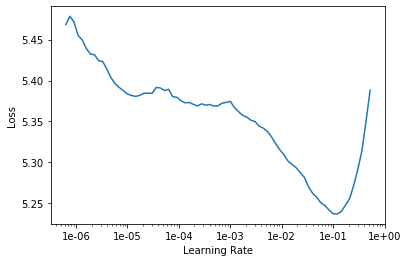

In [12]:
learn.recorder.plot(skip_end=15)

In [35]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.327817,4.167275,0.276956,2:25:43


In [36]:
learn.save('fit_head')

In [13]:
learn.load('fit_head');

To complete the fine-tuning, unfreeze and launch a new training (this takes 24 hours with full dataset!!!).

In [14]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.072336,4.001735,0.309790,2:44:45
1,3.870203,3.788206,0.324089,2:44:57
2,3.800969,3.715251,0.328850,2:44:57
3,3.761758,3.682413,0.331832,2:45:21
4,3.712821,3.652187,0.334605,2:44:40
5,3.675642,3.621999,0.337940,2:44:14
6,3.676834,3.591284,0.341628,2:44:13
7,3.625572,3.562270,0.344973,2:44:09
8,3.590290,3.545149,0.347131,2:44:21
9,3.566616,3.539950,0.347713,2:44:38


In [16]:
learn.save('fine_tuned')

How good is this model? Well let's try to see what it predicts after a few given words.

In [17]:
learn.load('fine_tuned');

In [18]:
TEXT = "I really need to get rid of some stuff because"
N_WORDS = 40
N_SENTENCES = 2

In [19]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I really need to get rid of some stuff because i do n't want to be a banned person . It 's been 3 months since i last posted . i had a really bad weekend at work and i got to spend a day with my gf and
I really need to get rid of some stuff because they 're my bi - monthly feelings i 'm not even sure if i 've been raped or not . It 's the first time someone ever told me that i 'm gay . i was trying to word


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [20]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Create a new data object for the classifier that uses the labelled data (takes a bit of time) and save result to save time on future runs

In [21]:
data_clas = TextClasDataBunch.from_csv(path, 'rspct.tsv', delimiter='\t',label_cols='subreddit',text_cols=['title','selftext'],vocab=data_lm.vocab)
data_clas.save('data_clas.pkl')

In [22]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [23]:
data_clas.show_batch()

text,target
"xxbos xxmaj potential xxmaj overwatch xxmaj easter xxmaj egg ? [ xxmaj this flag](https : / / imgur.com / a / xxunk ) is hung on a map in the game xxmaj overwatch . a [ close up](https : / / i.imgur.com / xxunk ) ( sorry for the poor quality , see below for cleaned up version ) shows a grid of squares that are either filled in or",codes
"xxbos [ 5e ] xxmaj grappler xxmaj cleric 1 / xxmaj wizard x xxmaj hi,<lb><lb > i want to build a grappler tank . xxmaj could you please review this build , giving suggestions if possible?<lb><lb > * i 'm not optimizing for level 20 . xxmaj rather , i look at level 10 - 12 at most . xxmaj the chances of actually playing a high level character are",3d6
"xxbos xxmaj darren xxmaj moore 's xxmaj second xxmaj great xxmaj escape - xxmaj west xxmaj xxunk xxmaj albion 2017 / 18 * * xxmaj first of all , this could all be over by xxmaj xxunk > xxmaj but the xxmaj escape starts with a lazy weekday evening in xxmaj wales , where * as low - scoring of a tie as possible * needs to happen - this",soccer
xxbos xxup happy xxup xxunk 💦 🦃 🦃 🦃 🍴 👅 👅 xxup turkey xxup isnt xxup the xxup only xxup thing xxup getting xxup stuffed 👌 🏻 👈 🏻 👅 😩 😩 😩 xxup happy xxup xxunk 💦 🦃 🦃 🦃 🍴 👅 👅 xxup turkey xxup isnt xxup the xxup only xxup thing xxup getting xxup stuffed 👌 🏻 👈 🏻 👅 😩 😩 😩 xxup youre xxup,emojipasta
"xxbos i ca n't tell if it 's me or ... i 'm on a weekend trip with my xxup so and their family . xxmaj the beginning of this year was rocky and i was having some hypomanic episodes . xxmaj however , i re - upped my self - monitoring and regulation mechanisms a month ago and re - entered the care of a counselor and got my",bipolar


In [24]:
data_clas.classes, data_clas.c, len(data_clas.train_ds), len(data_clas.valid_ds)

(['13ReasonsWhy',
  '3Dprinting',
  '3d6',
  '4Runner',
  '7daystodie',
  '90DayFiance',
  'ABDL',
  'ABraThatFits',
  'ACL',
  'ACT',
  'ADHD',
  'APStudents',
  'ASUS',
  'AcademicPsychology',
  'Accounting',
  'AdobeIllustrator',
  'Adoption',
  'AirBnB',
  'Allergies',
  'AlphaBayMarket',
  'AmericanHorrorStory',
  'Anarchism',
  'AndroidAuto',
  'Anki',
  'ApocalypseRising',
  'ArcherFX',
  'Archery',
  'AskAnthropology',
  'AskEconomics',
  'AskHR',
  'AskLiteraryStudies',
  'AskVet',
  'AstralProjection',
  'Audi',
  'AutoDetailing',
  'AutoHotkey',
  'AutoModerator',
  'AvPD',
  'Ayahuasca',
  'BATProject',
  'BDSMcommunity',
  'BMW',
  'BackYardChickens',
  'Bass',
  'BeardedDragons',
  'Beatmatch',
  'BeautyBoxes',
  'Bedbugs',
  'Beekeeping',
  'Berserk',
  'BigBrother',
  'Blacksmith',
  'Blink182',
  'BoJackHorseman',
  'BokuNoHeroAcademia',
  'Borderlands2',
  'Bowling',
  'BravoRealHousewives',
  'Brawlhalla',
  'Breadit',
  'CampHalfBloodRP',
  'CanadaPublicServants',
 

Create an AWD LSTM model to classify selfposts and load the saved encoder created above

In [25]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (810399 items)
x: TextList
xxbos xxmaj coming xxmaj out xxmaj advice xxmaj okay , so i am 19 years old and i have been in a relationship with a man ( i 'm a woman ) for over 5 years now . xxmaj he knows i 'm bisexual and i 'm at the point where i 'm ready to come out to everyone else . i want to come out to my immediate family first , but i 'm not sure how they 're going to take it . xxmaj what kind of advice would you give on doing this ? xxmaj i.e things to make sure to touch on , how to start the conversation , what to do if the conversation goes south , etc .,xxbos xxmaj finally xxmaj found my first gold weapon xxmaj it was ... okay.<lb><lb > xxmaj after couple of hours of tedious farming near the auto parts shop on the xxunk where you jump to the nearby tower and check what kind of weapon dropped there and after skipping couple of gold shotguns i have no use for i finally got it . xxmaj loco baseball bat . xxmaj and after 3 king

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


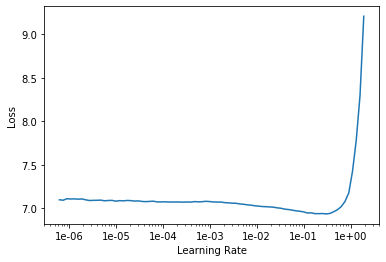

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.192041,1.476872,0.674266,44:08


In [29]:
learn.save('first')

In [30]:
learn.load('first');

In [31]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.842552,1.235800,0.722933,52:01


In [32]:
learn.save('second')

In [33]:
learn.load('second');

In [34]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.334051,0.953636,0.789335,1:11:19


In [35]:
learn.save('third')

In [36]:
learn.load('third');

In [37]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.241281,0.911107,0.798086,1:55:18
1,1.122882,0.854056,0.810731,1:54:32


In [38]:
learn.predict("I just removed EVERYthing from the top of my fridge. Each thing is now either in the trash, donate box, or put away where it belongs and I don't have to see it. Took me all of 5 minutes!")

(Category declutter,
 tensor(546),
 tensor([2.8892e-05, 6.0846e-05, 7.2840e-06,  ..., 2.7603e-05, 1.3389e-05,
         7.0968e-05]))

In [39]:
learn.predict("going to visit venice in September what should I wear")

(Category italy,
 tensor(672),
 tensor([1.2239e-07, 1.8982e-06, 9.6384e-07,  ..., 2.4309e-08, 4.1980e-06,
         2.5045e-06]))